In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from Bio.Phylo._io import parse
from Bio.Phylo.BaseTree import Tree as BioTree

from src.utils.tree_utils import get_taxa_names
from src.utils.tree_utils import get_tree_height
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [3]:
from phylodata import load_experiment
from phylodata import FileType
experiment = load_experiment(
	"tanoyo-2024-systematics-5flw",
	version=2,
	directory=Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/phylodata")
)

In [4]:


REFERENCE_TREE_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/mcmc/yule-50-1.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Shorter Branch (Gamma) (per partition)_samples.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Height (LogNormal) Ratio (Beta) (per partition)_samples.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Height (LogNormal) Ratio (Beta) Copula (per partition)_samples.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Height-Ratio AR(1) + Global (per partition) true_samples.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Dirichlet (LogNormal)_samples.trees")
SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_Height (LogNormal) Ratio (ExpBeta) (per partition)_samples.trees")

# REFERENCE_TREE_FILE = experiment.get_file_of_type(FileType.POSTERIOR_TREES).local_path
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Height (LogNormal) Ratio (ExpBeta) (per partition)_samples.trees")
# SAMPLE_TREES_FILE = Path("/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/phylodata-phylodata-tanoyo_2024_systematics_5flwiskandari_beast_run1_Height (LogNormal) Ratio (Beta) Copula (per partition)_samples.trees")

In [5]:
ref_trees: list[BioTree] = list(parse(REFERENCE_TREE_FILE, "nexus"))
taxa_names = get_taxa_names(ref_trees[0])
ref_nodes, ref_clade_splits = get_observed_nodes(ref_trees, taxa_names)
df_ref_clade_branches = get_clade_split_df(ref_clade_splits)

In [69]:
sample_trees: list[BioTree] = list(parse(SAMPLE_TREES_FILE, "nexus"))

In [70]:
ref_tree_heights = [
    get_tree_height(tree)
    for tree in ref_trees   
]
sample_tree_heights = [
    get_tree_height(tree)
    for tree in sample_trees
]

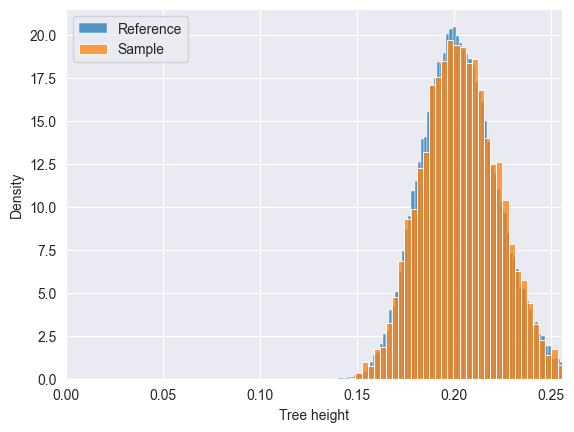

In [71]:
import numpy as np

max_displayed_height = np.percentile(sample_tree_heights + sample_tree_heights, 99)

sns.histplot(
    ref_tree_heights,
    stat="density",
    label="Reference",
)
sns.histplot(
    sample_tree_heights,
    stat="density",
    label="Sample",
)

plt.xlabel("Tree height")
plt.xlim(0, max_displayed_height)
plt.legend()

plt.savefig("test.png", dpi=200)
plt.show()

In [72]:
sample_nodes, sample_clade_splits = get_observed_nodes(sample_trees, taxa_names)

In [73]:
df_sample_clade_branches = get_clade_split_df(sample_clade_splits)

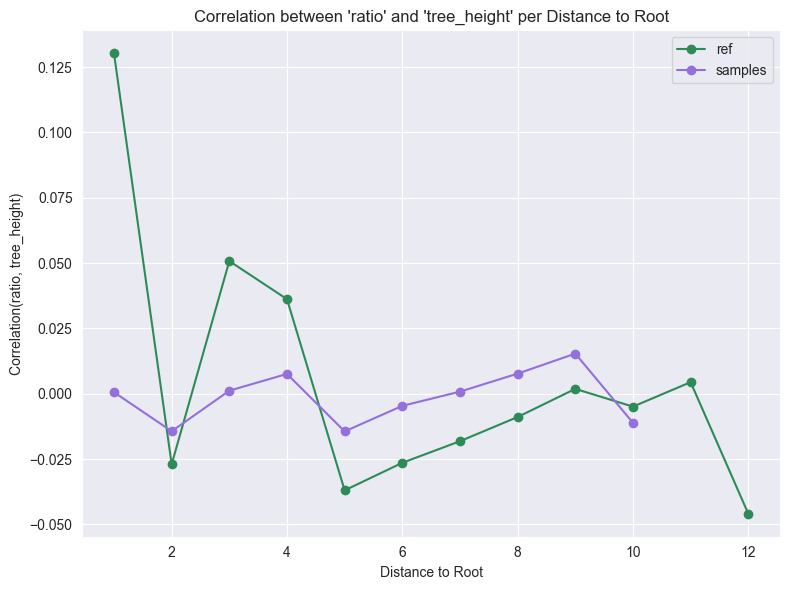

In [74]:
# Plot the correlation of 'ratio' and 'tree_height' per unique distance_to_root value (distance as x-axis, correlation as y-axis)
# Here, distance_to_root is assumed to be integer-valued

corrs_ref = []
corrs_sample = []
distance_values = sorted(set(df_ref_clade_branches['distance_to_root'].unique()) |
                        set(df_sample_clade_branches['distance_to_root'].unique()))

for d in distance_values:
    subref = df_ref_clade_branches[df_ref_clade_branches['distance_to_root'] == d]
    subsample = df_sample_clade_branches[df_sample_clade_branches['distance_to_root'] == d]
    corr_ref = subref[['ratio','tree_height']].corr().iloc[0,1] if len(subref) > 1 else np.nan
    corr_sample = subsample[['ratio','tree_height']].corr().iloc[0,1] if len(subsample) > 1 else np.nan
    corrs_ref.append(corr_ref if len(subref) > 5000 else np.nan)
    corrs_sample.append(corr_sample if len(subsample) > 5000 else np.nan)

plt.figure(figsize=(8,6))
plt.plot(distance_values, corrs_ref, marker='o', label='ref', color='seagreen')
plt.plot(distance_values, corrs_sample, marker='o', label='samples', color='mediumpurple')
plt.xlabel("Distance to Root")
plt.ylabel("Correlation(ratio, tree_height)")
plt.title("Correlation between 'ratio' and 'tree_height' per Distance to Root")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

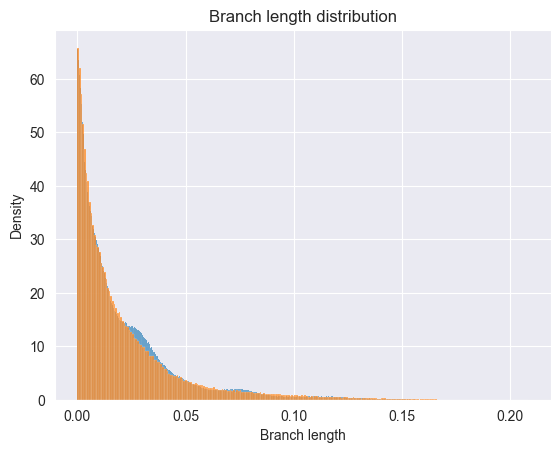

In [75]:
sns.histplot(
    df_ref_clade_branches["left_branch"], 
    stat="density",
)

sns.histplot(
    df_sample_clade_branches["left_branch"], 
    stat="density",
)

plt.xlabel("Branch length")
plt.title("Branch length distribution")
plt.show()

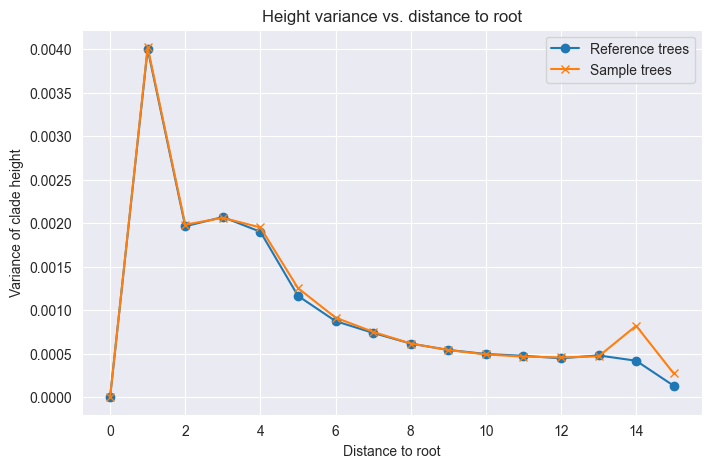

In [76]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate variance of height at each distance
variances_ref = df_ref_clade_branches.groupby("distance_to_root")["height"].var()
variances_sample = df_sample_clade_branches.groupby("distance_to_root")["height"].var()

plt.figure(figsize=(8,5))
plt.plot(variances_ref.index, variances_ref.values, marker='o', label='Reference trees')
plt.plot(variances_sample.index, variances_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Variance of clade height")
plt.title("Height variance vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

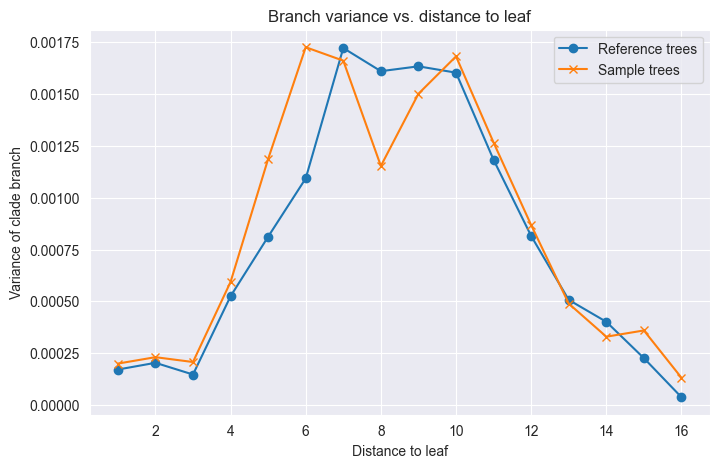

In [77]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate variance of height at each distance
variances_ref = df_ref_clade_branches.groupby("distance_to_leaf")["left_branch"].var()
variances_sample = df_sample_clade_branches.groupby("distance_to_leaf")["left_branch"].var()

plt.figure(figsize=(8,5))
plt.plot(variances_ref.index, variances_ref.values, marker='o', label='Reference trees')
plt.plot(variances_sample.index, variances_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to leaf")
plt.ylabel("Variance of clade branch")
plt.title("Branch variance vs. distance to leaf")
plt.legend()
plt.grid(True)
plt.show()

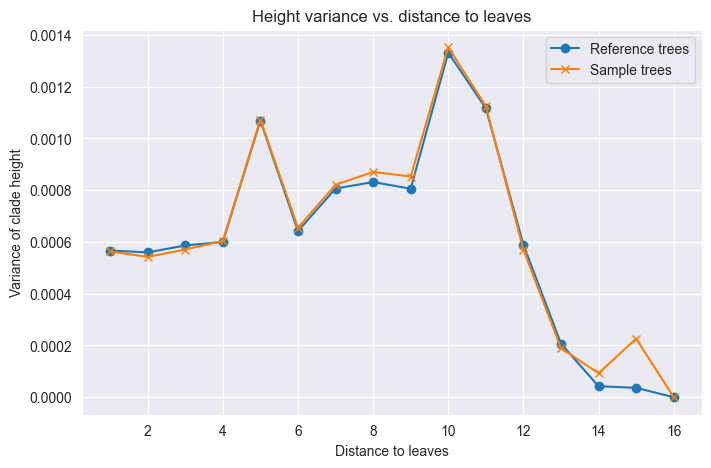

In [78]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate variance of height at each distance
variances_ref = df_ref_clade_branches.groupby("distance_to_leaf")["height"].var()
variances_sample = df_sample_clade_branches.groupby("distance_to_leaf")["height"].var()

plt.figure(figsize=(8,5))
plt.plot(variances_ref.index, variances_ref.values, marker='o', label='Reference trees')
plt.plot(variances_sample.index, variances_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to leaves")
plt.ylabel("Variance of clade height")
plt.title("Height variance vs. distance to leaves")
plt.legend()
plt.grid(True)
plt.show()

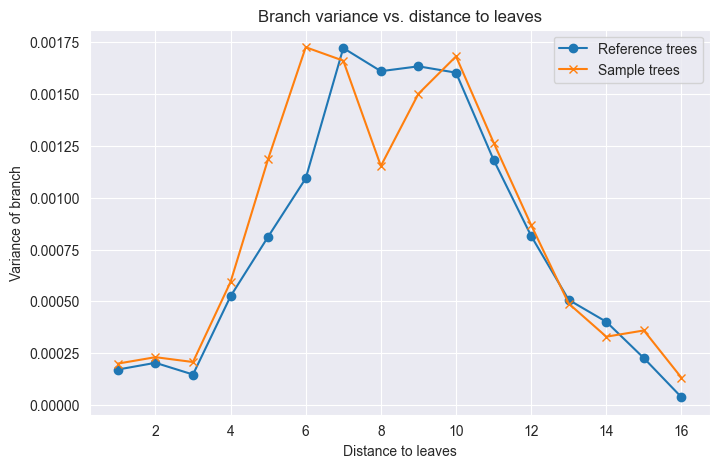

In [79]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate variance of height at each distance
variances_ref = df_ref_clade_branches.groupby("distance_to_leaf")["left_branch"].var()
variances_sample = df_sample_clade_branches.groupby("distance_to_leaf")["left_branch"].var()

plt.figure(figsize=(8,5))
plt.plot(variances_ref.index, variances_ref.values, marker='o', label='Reference trees')
plt.plot(variances_sample.index, variances_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to leaves")
plt.ylabel("Variance of branch")
plt.title("Branch variance vs. distance to leaves")
plt.legend()
plt.grid(True)
plt.show()

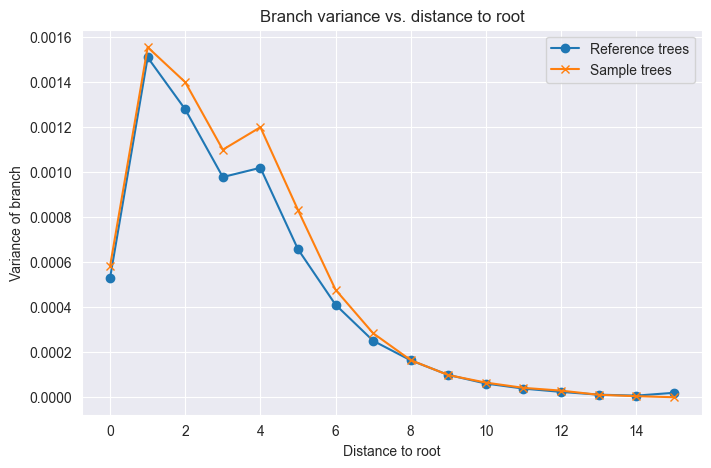

In [80]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate variance of height at each distance
variances_ref = df_ref_clade_branches.groupby("distance_to_root")["left_branch"].var()
variances_sample = df_sample_clade_branches.groupby("distance_to_root")["left_branch"].var()

plt.figure(figsize=(8,5))
plt.plot(variances_ref.index, variances_ref.values, marker='o', label='Reference trees')
plt.plot(variances_sample.index, variances_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Variance of branch")
plt.title("Branch variance vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

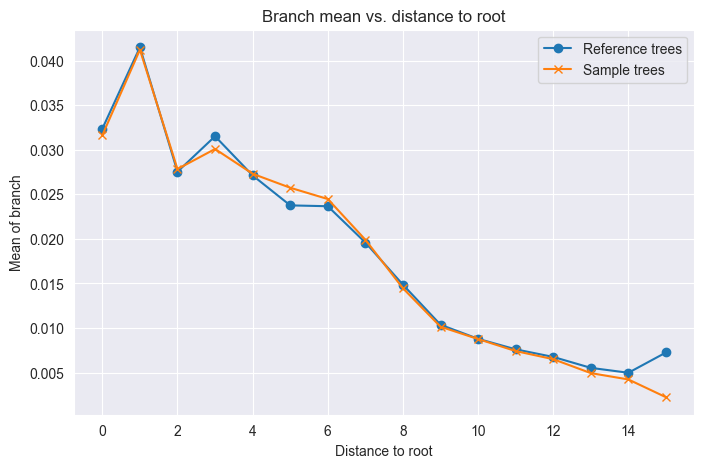

In [81]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate mean of height at each distance
means_ref = df_ref_clade_branches.groupby("distance_to_root")["left_branch"].mean()
means_sample = df_sample_clade_branches.groupby("distance_to_root")["left_branch"].mean()

plt.figure(figsize=(8,5))
plt.plot(means_ref.index, means_ref.values, marker='o', label='Reference trees')
plt.plot(means_sample.index, means_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Mean of branch")
plt.title("Branch mean vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

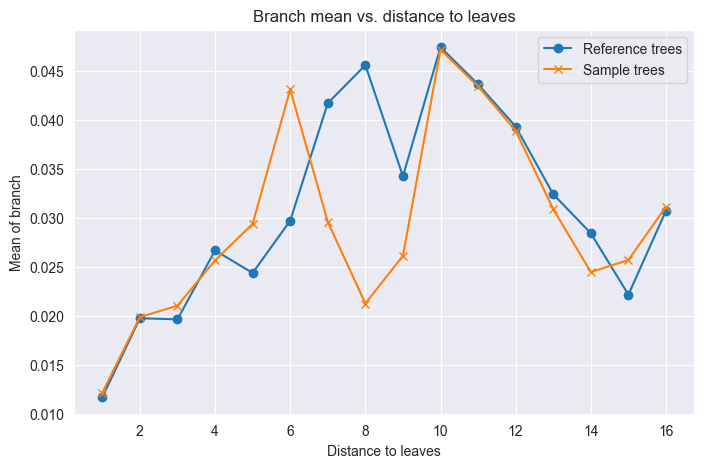

In [82]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate mean of height at each distance
means_ref = df_ref_clade_branches.groupby("distance_to_leaf")["left_branch"].mean()
means_sample = df_sample_clade_branches.groupby("distance_to_leaf")["left_branch"].mean()

plt.figure(figsize=(8,5))
plt.plot(means_ref.index, means_ref.values, marker='o', label='Reference trees')
plt.plot(means_sample.index, means_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to leaves")
plt.ylabel("Mean of branch")
plt.title("Branch mean vs. distance to leaves")
plt.legend()
plt.grid(True)
plt.show()

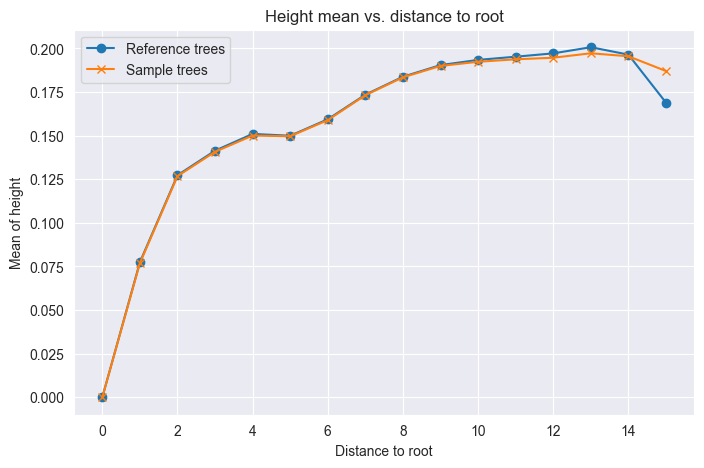

In [83]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate mean of height at each distance
means_ref = df_ref_clade_branches.groupby("distance_to_root")["height"].mean()
means_sample = df_sample_clade_branches.groupby("distance_to_root")["height"].mean()

plt.figure(figsize=(8,5))
plt.plot(means_ref.index, means_ref.values, marker='o', label='Reference trees')
plt.plot(means_sample.index, means_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Mean of height")
plt.title("Height mean vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

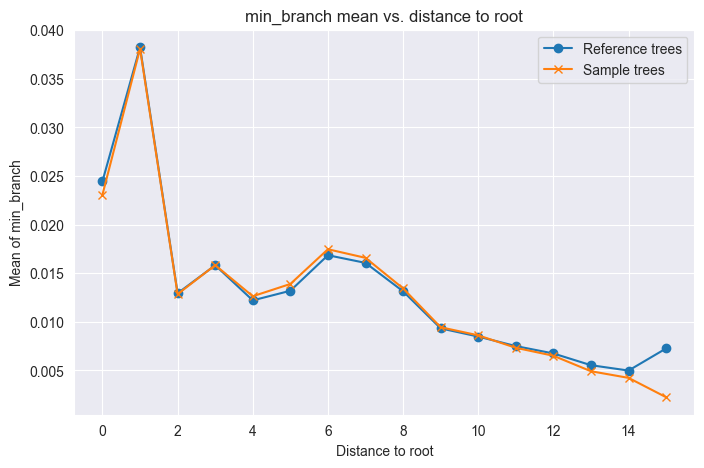

In [84]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate mean of height at each distance
means_ref = df_ref_clade_branches.groupby("distance_to_root")["min_branch"].mean()
means_sample = df_sample_clade_branches.groupby("distance_to_root")["min_branch"].mean()

plt.figure(figsize=(8,5))
plt.plot(means_ref.index, means_ref.values, marker='o', label='Reference trees')
plt.plot(means_sample.index, means_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Mean of min_branch")
plt.title("min_branch mean vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

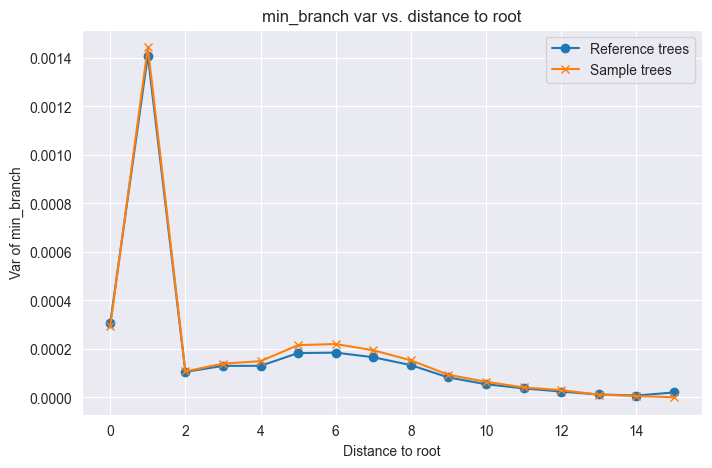

In [85]:
import matplotlib.pyplot as plt

# Group by distance_to_root, calculate mean of height at each distance
means_ref = df_ref_clade_branches.groupby("distance_to_root")["min_branch"].var()
means_sample = df_sample_clade_branches.groupby("distance_to_root")["min_branch"].var()

plt.figure(figsize=(8,5))
plt.plot(means_ref.index, means_ref.values, marker='o', label='Reference trees')
plt.plot(means_sample.index, means_sample.values, marker='x', label='Sample trees')
plt.xlabel("Distance to root")
plt.ylabel("Var of min_branch")
plt.title("min_branch var vs. distance to root")
plt.legend()
plt.grid(True)
plt.show()

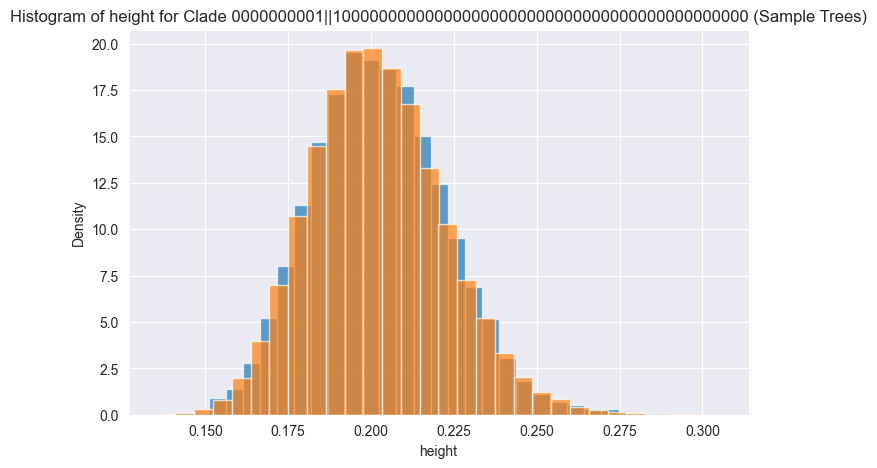

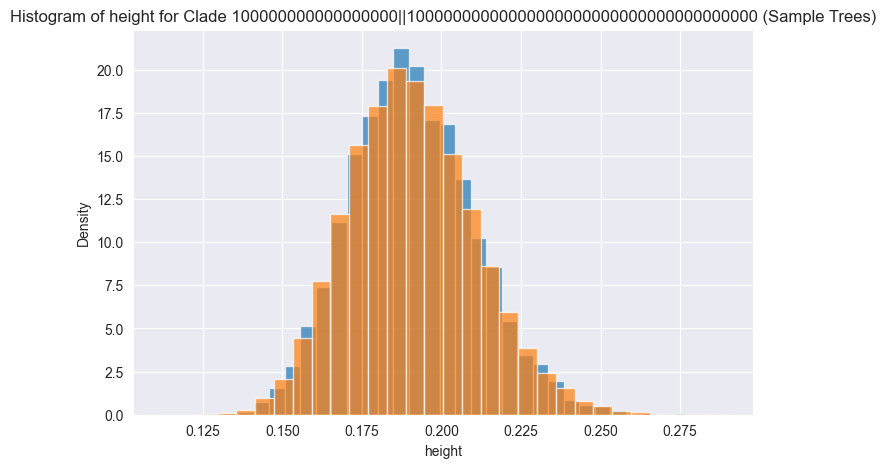

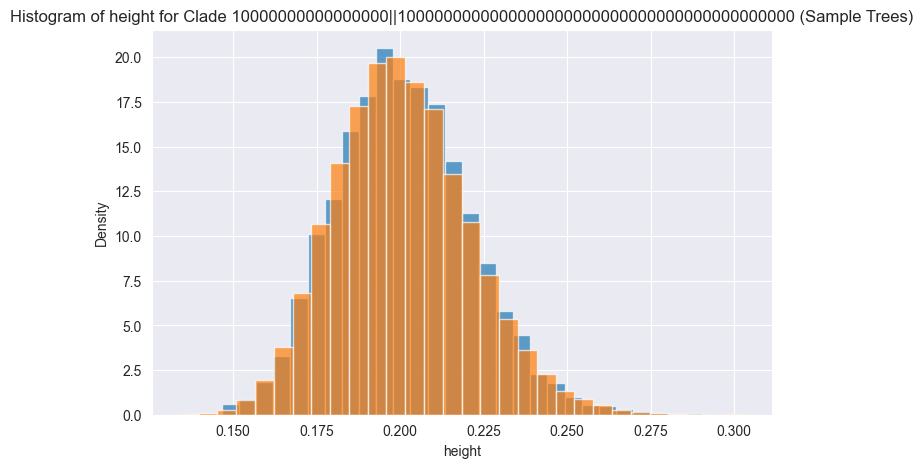

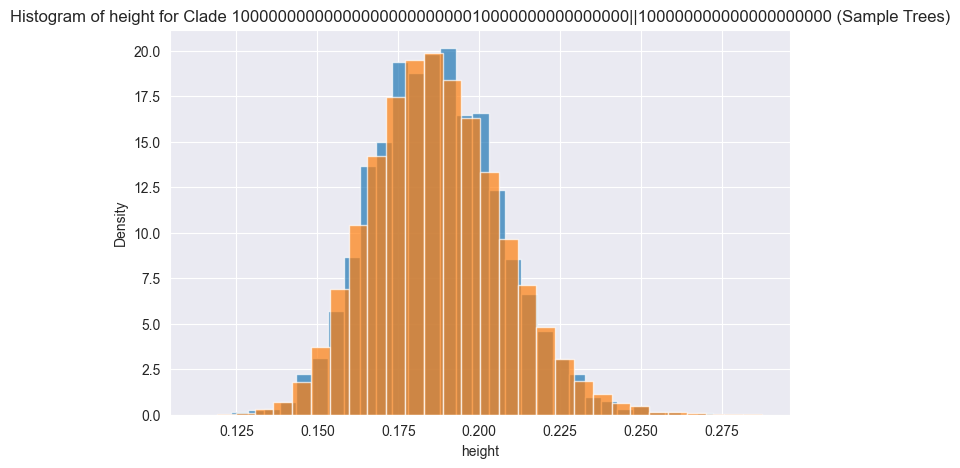

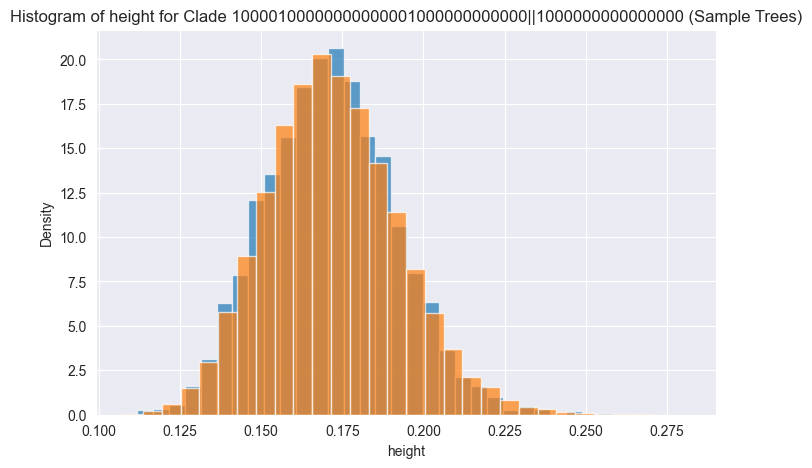

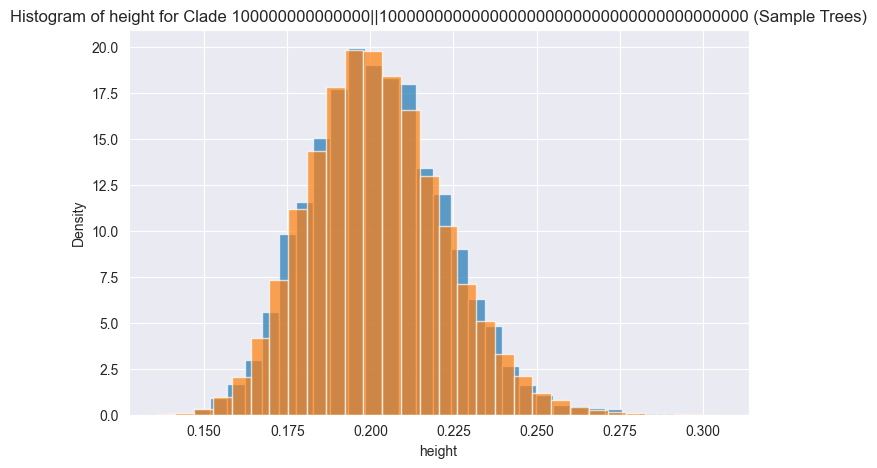

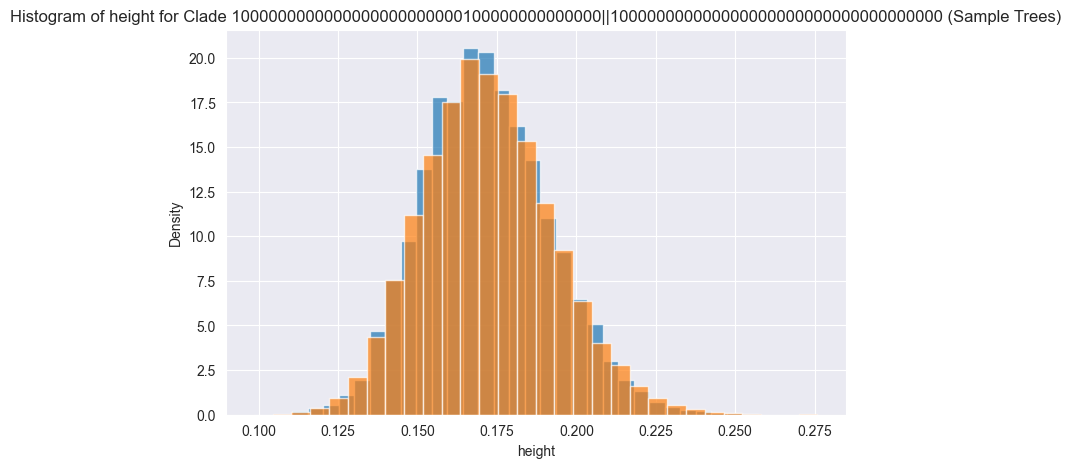

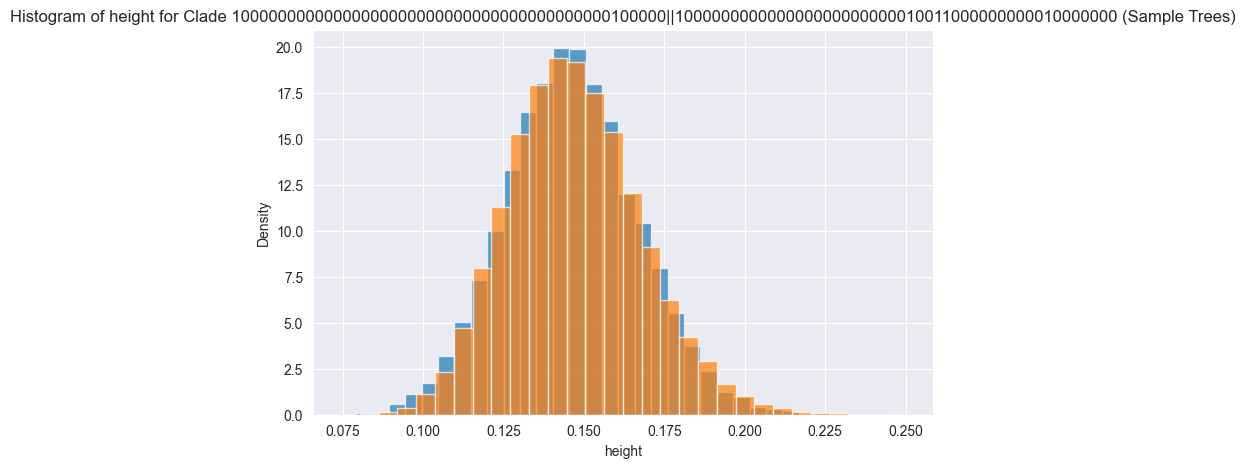

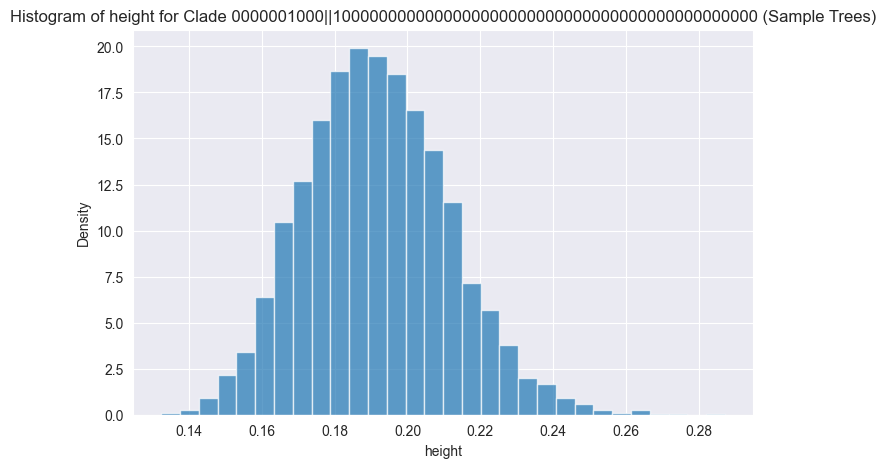

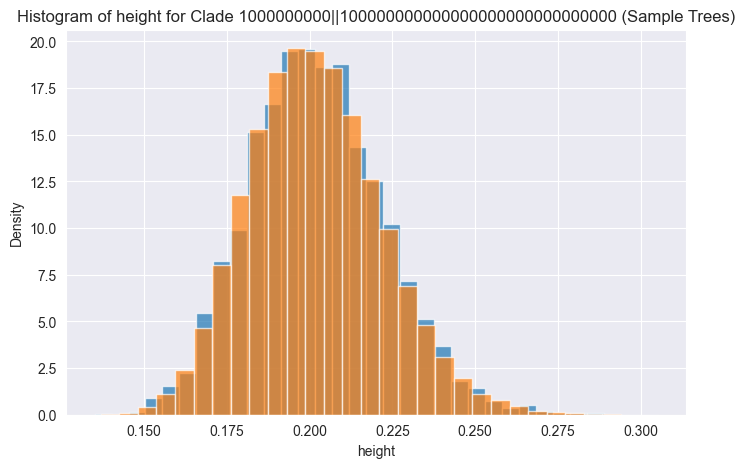

In [86]:
import matplotlib.pyplot as plt

# Find the 5 most common clade_splits in df_sample_clade_branches
top_clades = df_sample_clade_branches['clade_split'].value_counts().head(10).index

for clade in top_clades:
    subset_ref = df_ref_clade_branches[df_ref_clade_branches['clade_split'] == clade]
    subset = df_sample_clade_branches[df_sample_clade_branches['clade_split'] == clade]
    frac_ref = subset_ref["height"]
    frac_sample = subset["height"]
    plt.figure(figsize=(8,5))
    plt.hist(frac_sample, bins=30, alpha=0.7, color='C0', density=True)
    plt.hist(frac_ref, bins=30, alpha=0.7, color='C1', density=True)
    plt.xlabel('height')
    plt.ylabel('Density')
    plt.title(f'Histogram of height for Clade {clade} (Sample Trees)')
    plt.grid(True)
    plt.show()


In [87]:
import pandas as pd

df_credible_sets = pd.read_csv(
    "/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-1_credible_sets.log",
    delimiter=";"
)
df_estimator_credible_sets = pd.read_csv(
    "/Users/ochsneto/Documents/TreeDistributions/ccd-validation/data/processed/yule-50-2_estimator_credible_sets.log",
    delimiter=";"
)

In [88]:
df_credible_sets["distribution"].unique()

array(['Height (LogNormal) Ratio (ExpBeta) (per partition)',
       'Height (LogNormal) Ratio (Beta) Copula (per partition)'],
      dtype=object)

<Axes: xlabel='sample_credible_set', ylabel='Density'>

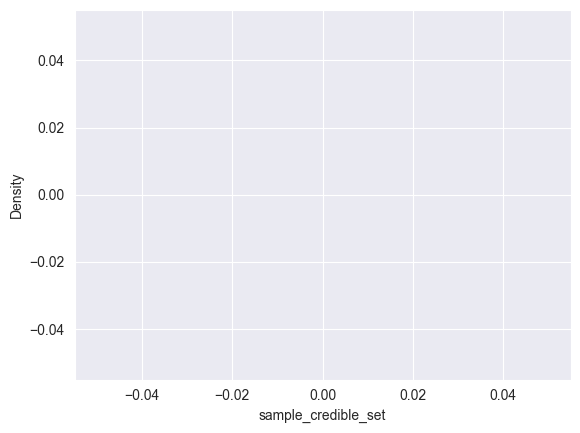

In [89]:
MODEL_NAME = "Height-Ratio AR(1) + Global (per partition) false"

sns.histplot(
    data=df_estimator_credible_sets[df_estimator_credible_sets.distribution == MODEL_NAME],
    x="sample_credible_set",
    stat="density"
)
sns.histplot(
    data=df_credible_sets[df_credible_sets.distribution == MODEL_NAME],
    x="sample_credible_set",
    stat="density"
)

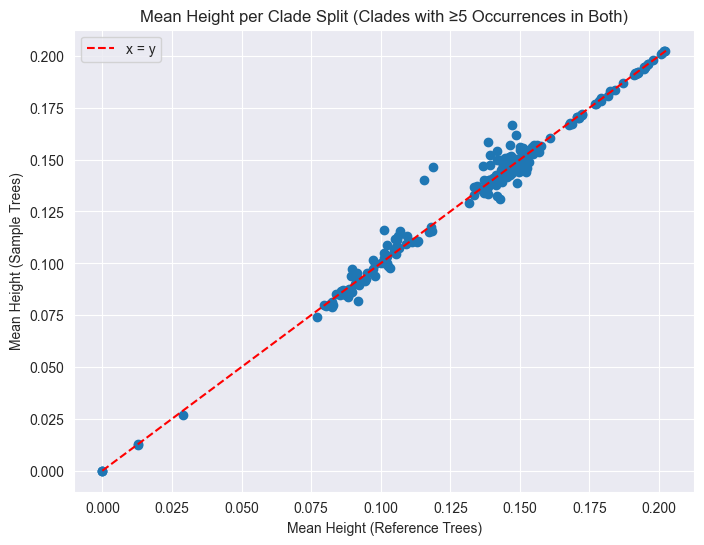

In [90]:
import matplotlib.pyplot as plt

# Count clade_split occurrences in both dataframes
sample_counts = df_sample_clade_branches['clade_split'].value_counts()
ref_counts = df_ref_clade_branches['clade_split'].value_counts()

# Find clade_splits appearing at least 5 times in both dataframes
eligible_clades = set(sample_counts[sample_counts >= 5].index) & set(ref_counts[ref_counts >= 5].index)

# Compute mean height for each eligible clade_split in both dataframes
sample_means = df_sample_clade_branches[df_sample_clade_branches['clade_split'].isin(eligible_clades)].groupby('clade_split')['height'].mean()
ref_means = df_ref_clade_branches[df_ref_clade_branches['clade_split'].isin(eligible_clades)].groupby('clade_split')['height'].mean()

# Ensure same order
common_clades = sorted(list(eligible_clades))
sample_heights = sample_means.loc[common_clades]
ref_heights = ref_means.loc[common_clades]

plt.figure(figsize=(8, 6))
plt.scatter(ref_heights, sample_heights)
# draw x=y line for comparison
min_val = min(ref_heights.min(), sample_heights.min())
max_val = max(ref_heights.max(), sample_heights.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')
plt.xlabel("Mean Height (Reference Trees)")
plt.ylabel("Mean Height (Sample Trees)")
plt.title("Mean Height per Clade Split (Clades with ≥5 Occurrences in Both)")
plt.grid(True)
plt.legend()
plt.show()

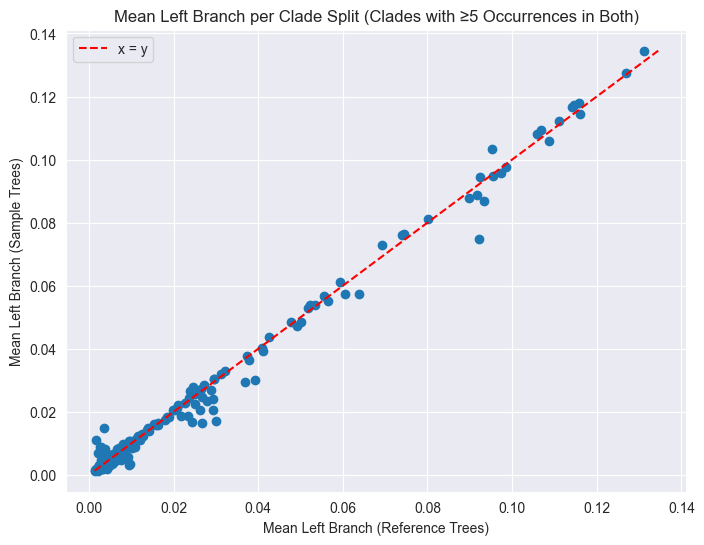

In [91]:
# Display the mean left_branch for each eligible clade_split

# Count clade_split occurrences in both dataframes
sample_counts = df_sample_clade_branches['clade_split'].value_counts()
ref_counts = df_ref_clade_branches['clade_split'].value_counts()

# Find clade_splits appearing at least 5 times in both dataframes
eligible_clades = set(sample_counts[sample_counts >= 5].index) & set(ref_counts[ref_counts >= 5].index)

# Compute mean left_branch for each eligible clade_split in both dataframes
sample_left_means = df_sample_clade_branches[df_sample_clade_branches['clade_split'].isin(eligible_clades)].groupby('clade_split')['left_branch'].mean()
ref_left_means = df_ref_clade_branches[df_ref_clade_branches['clade_split'].isin(eligible_clades)].groupby('clade_split')['left_branch'].mean()

# Ensure same order
common_clades = sorted(list(eligible_clades))
sample_left_vals = sample_left_means.loc[common_clades]
ref_left_vals = ref_left_means.loc[common_clades]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(ref_left_vals, sample_left_vals)
# draw x=y line for comparison
min_val = min(ref_left_vals.min(), sample_left_vals.min())
max_val = max(ref_left_vals.max(), sample_left_vals.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')
plt.xlabel("Mean Left Branch (Reference Trees)")
plt.ylabel("Mean Left Branch (Sample Trees)")
plt.title("Mean Left Branch per Clade Split (Clades with ≥5 Occurrences in Both)")
plt.grid(True)
plt.legend()
plt.show()

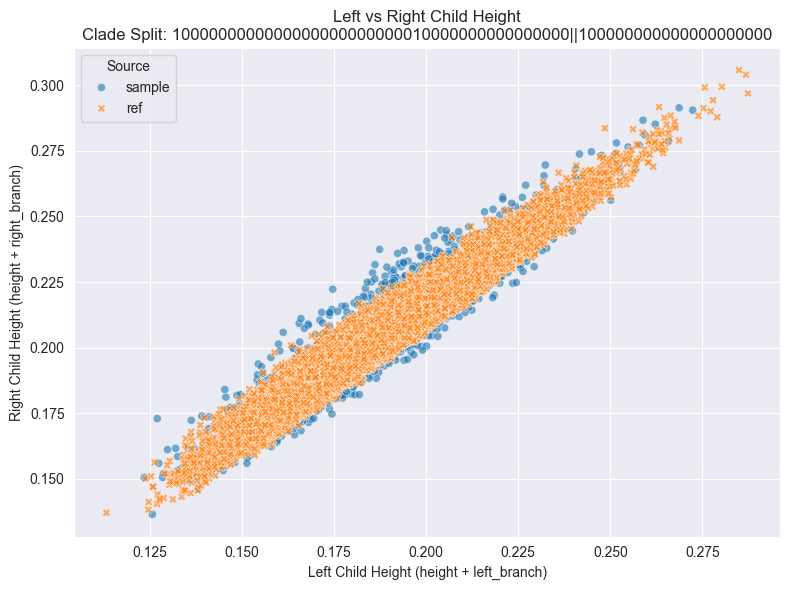

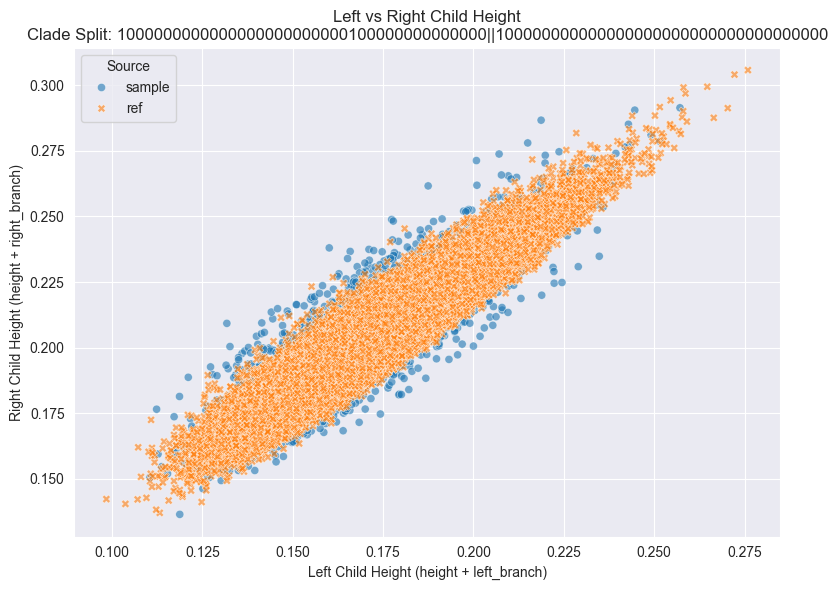

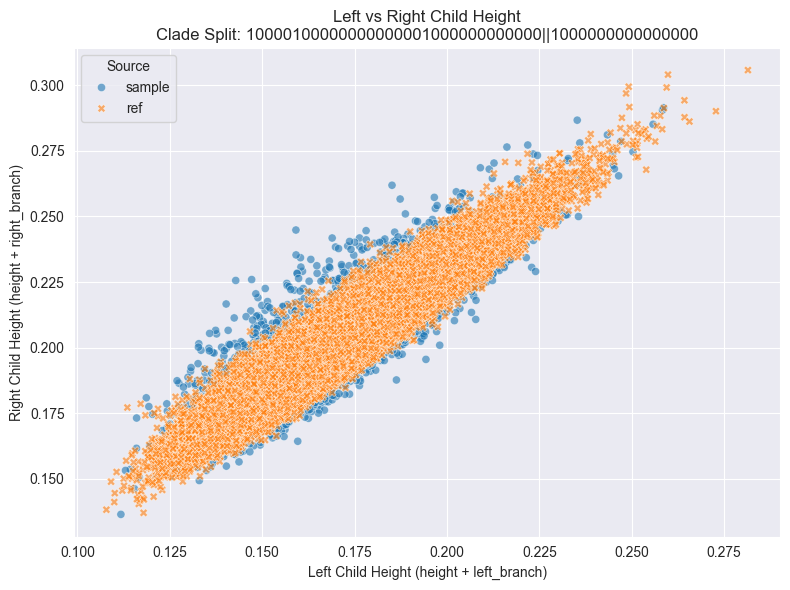

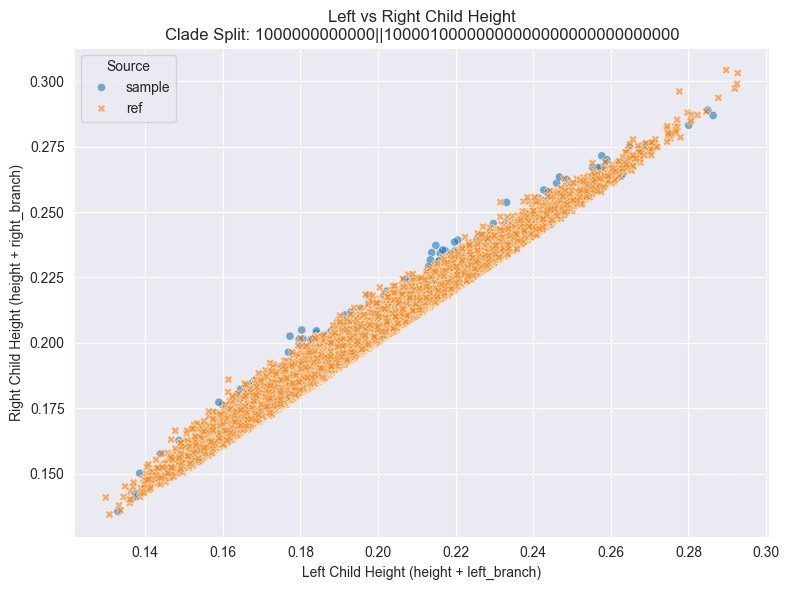

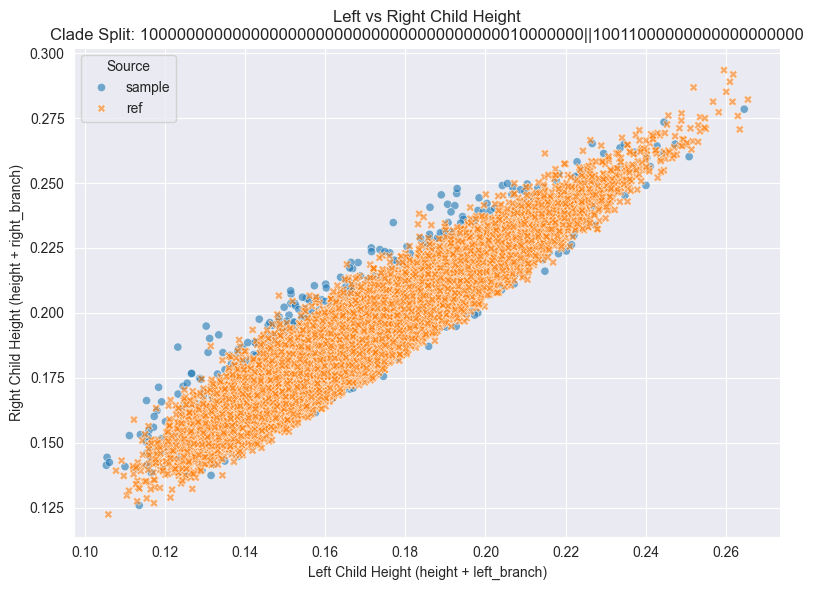

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Identify the 15 most common clade splits based on combined frequency in both dataframes
# Ignore cherries (clades with distance_to_leaf == 1)
sample_non_cherries = df_sample_clade_branches[df_sample_clade_branches['distance_to_leaf'] > 1]
ref_non_cherries = df_ref_clade_branches[df_ref_clade_branches['distance_to_leaf'] > 1]
sample_counts = sample_non_cherries['clade_split'].value_counts()
ref_counts = ref_non_cherries['clade_split'].value_counts()
total_counts = (sample_counts + ref_counts).fillna(0)
top15_clades = total_counts.nlargest(5).index

# Prepare data for plotting
def prepare_scatter_df(df, source_label, clade_split, subsample_to=None, random_state=None):
    df_filtered = df[df['clade_split'] == clade_split].copy()
    if subsample_to is not None and len(df_filtered) > subsample_to:
        df_filtered = df_filtered.sample(n=subsample_to, random_state=random_state)
    df_filtered['right_child_height'] = df_filtered['height'] + df_filtered['right_branch']
    df_filtered['source'] = source_label
    return df_filtered

for clade in top15_clades:
    df_ref_plot = prepare_scatter_df(df_ref_clade_branches, "ref", clade)
    df_sample_plot = prepare_scatter_df(df_sample_clade_branches, "sample", clade, len(df_ref_plot))
    scatter_df = pd.concat([df_sample_plot, df_ref_plot], ignore_index=True)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=scatter_df,
        x="height",
        y="right_child_height",
        hue="source",
        style="source",
        alpha=0.6,
        s=35
    )
    plt.title(f"Left vs Right Child Height\nClade Split: {clade}")
    plt.xlabel("Left Child Height (height + left_branch)")
    plt.ylabel("Right Child Height (height + right_branch)")
    plt.grid(True)
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()

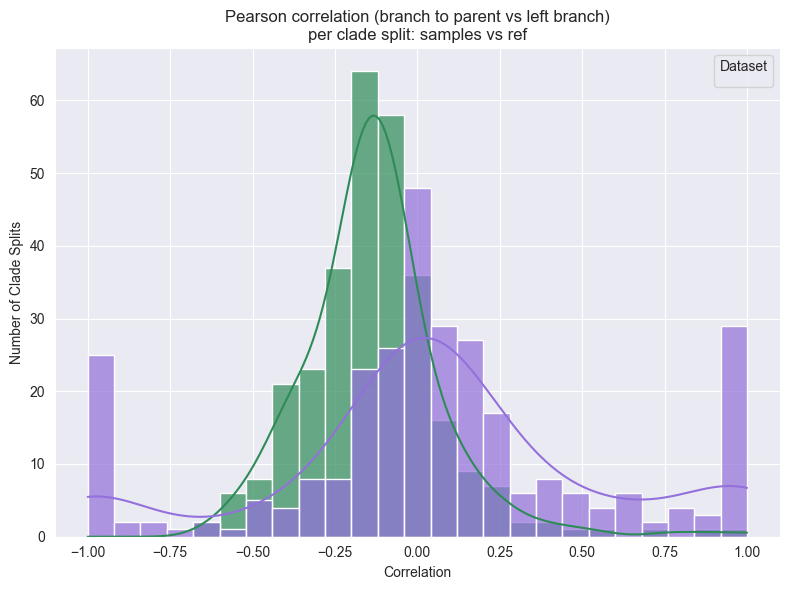

In [93]:
# 2. For each clade_split, calculate Pearson correlation in both sample and reference
def per_clade_child_corr(df):
    return (
        df.groupby('clade_split')
        .apply(
            lambda grp: grp['branch_to_parent'].corr(grp['left_branch'])
            if len(grp) > 1 else None
        )
        .dropna()
        .rename('correlation')
        .reset_index()
    )

sample_corr = per_clade_child_corr(df_sample_clade_branches).rename(columns={'correlation': 'correlation_sample'})
ref_corr = per_clade_child_corr(df_ref_clade_branches).rename(columns={'correlation': 'correlation_ref'})

# 3. Merge on clade_split -- only keep clade splits present in both for fair comparison
common_corrs = pd.merge(
    sample_corr,
    ref_corr,
    on='clade_split',
    how='inner'
)

# 4. Combine correlations into long format for joint histogram plotting
corrs_long = pd.melt(
    common_corrs,
    id_vars=['clade_split'],
    value_vars=['correlation_sample', 'correlation_ref'],
    var_name='dataset',
    value_name='correlation'
)
# Remap to 'samples' and 'ref' for legend
corrs_long['dataset'] = corrs_long['dataset'].map({
    'correlation_sample': 'samples',
    'correlation_ref': 'ref'
})

# 5. Plot histogram of the correlations for both sample and reference with legend "ref" and "samples"
plt.figure(figsize=(8,6))
ax = sns.histplot(
    data=corrs_long,
    x='correlation',
    hue='dataset',
    bins=25,
    kde=True,
    alpha=0.7,
    palette={'samples': 'mediumpurple', 'ref': 'seagreen'}
)
plt.title("Pearson correlation (branch to parent vs left branch)\nper clade split: samples vs ref")
plt.xlabel("Correlation")
plt.ylabel("Number of Clade Splits")
plt.grid(True)
plt.tight_layout()

# Custom legend with order: 'ref', 'samples'
handles, labels = ax.get_legend_handles_labels()
new_labels = []
new_handles = []
# Ensure correct legend order
label_order = ['ref', 'samples']
for name in label_order:
    for (h, l) in zip(handles, labels):
        if l == name:
            new_handles.append(h)
            new_labels.append(l)
ax.legend(handles=new_handles, labels=new_labels, title='Dataset', loc='best', frameon=True)

plt.show()


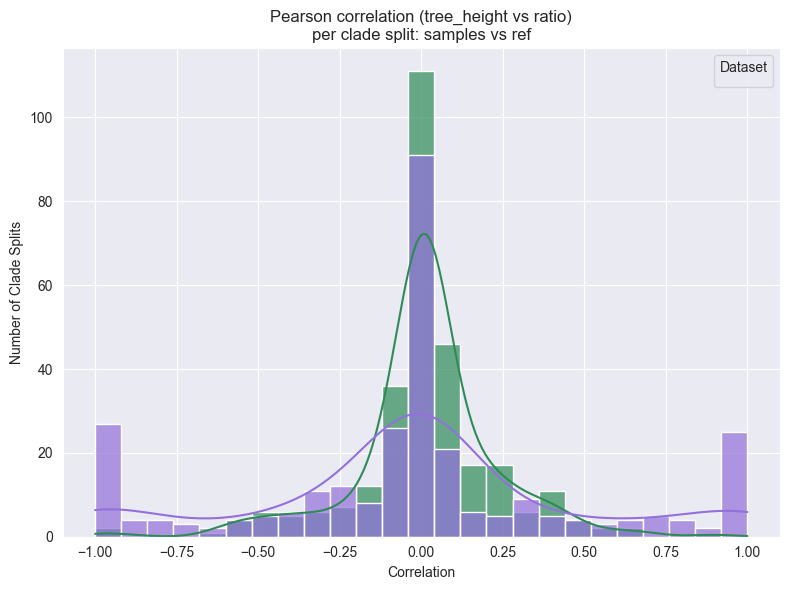

In [94]:
# 2. For each clade_split, calculate Pearson correlation in both sample and reference
def per_clade_child_corr(df):
    return (
        df.groupby('clade_split')
        .apply(
            lambda grp: grp['tree_height'].corr(grp['ratio'])
            if len(grp) > 1 else None
        )
        .dropna()
        .rename('correlation')
        .reset_index()
    )

sample_corr = per_clade_child_corr(df_sample_clade_branches).rename(columns={'correlation': 'correlation_sample'})
ref_corr = per_clade_child_corr(df_ref_clade_branches).rename(columns={'correlation': 'correlation_ref'})

# 3. Merge on clade_split -- only keep clade splits present in both for fair comparison
common_corrs = pd.merge(
    sample_corr,
    ref_corr,
    on='clade_split',
    how='inner'
)

# 4. Combine correlations into long format for joint histogram plotting
corrs_long = pd.melt(
    common_corrs,
    id_vars=['clade_split'],
    value_vars=['correlation_sample', 'correlation_ref'],
    var_name='dataset',
    value_name='correlation'
)
# Remap to 'samples' and 'ref' for legend
corrs_long['dataset'] = corrs_long['dataset'].map({
    'correlation_sample': 'samples',
    'correlation_ref': 'ref'
})

# 5. Plot histogram of the correlations for both sample and reference with legend "ref" and "samples"
plt.figure(figsize=(8,6))
ax = sns.histplot(
    data=corrs_long,
    x='correlation',
    hue='dataset',
    bins=25,
    kde=True,
    alpha=0.7,
    palette={'samples': 'mediumpurple', 'ref': 'seagreen'}
)
plt.title("Pearson correlation (tree_height vs ratio)\nper clade split: samples vs ref")
plt.xlabel("Correlation")
plt.ylabel("Number of Clade Splits")
plt.grid(True)
plt.tight_layout()

# Custom legend with order: 'ref', 'samples'
handles, labels = ax.get_legend_handles_labels()
new_labels = []
new_handles = []
# Ensure correct legend order
label_order = ['ref', 'samples']
for name in label_order:
    for (h, l) in zip(handles, labels):
        if l == name:
            new_handles.append(h)
            new_labels.append(l)
ax.legend(handles=new_handles, labels=new_labels, title='Dataset', loc='best', frameon=True)

plt.show()


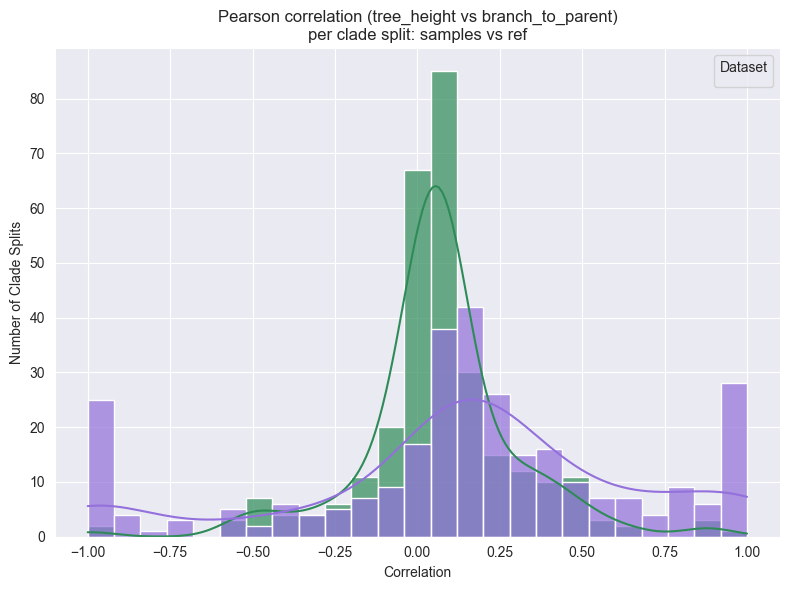

In [95]:
# 2. For each clade_split, calculate Pearson correlation in both sample and reference
def per_clade_child_corr(df):
    return (
        df.groupby('clade_split')
        .apply(
            lambda grp: grp['tree_height'].corr(grp['branch_to_parent'])
            if len(grp) > 1 else None
        )
        .dropna()
        .rename('correlation')
        .reset_index()
    )

sample_corr = per_clade_child_corr(df_sample_clade_branches).rename(columns={'correlation': 'correlation_sample'})
ref_corr = per_clade_child_corr(df_ref_clade_branches).rename(columns={'correlation': 'correlation_ref'})

# 3. Merge on clade_split -- only keep clade splits present in both for fair comparison
common_corrs = pd.merge(
    sample_corr,
    ref_corr,
    on='clade_split',
    how='inner'
)

# 4. Combine correlations into long format for joint histogram plotting
corrs_long = pd.melt(
    common_corrs,
    id_vars=['clade_split'],
    value_vars=['correlation_sample', 'correlation_ref'],
    var_name='dataset',
    value_name='correlation'
)
# Remap to 'samples' and 'ref' for legend
corrs_long['dataset'] = corrs_long['dataset'].map({
    'correlation_sample': 'samples',
    'correlation_ref': 'ref'
})

# 5. Plot histogram of the correlations for both sample and reference with legend "ref" and "samples"
plt.figure(figsize=(8,6))
ax = sns.histplot(
    data=corrs_long,
    x='correlation',
    hue='dataset',
    bins=25,
    kde=True,
    alpha=0.7,
    palette={'samples': 'mediumpurple', 'ref': 'seagreen'}
)
plt.title("Pearson correlation (tree_height vs branch_to_parent)\nper clade split: samples vs ref")
plt.xlabel("Correlation")
plt.ylabel("Number of Clade Splits")
plt.grid(True)
plt.tight_layout()

# Custom legend with order: 'ref', 'samples'
handles, labels = ax.get_legend_handles_labels()
new_labels = []
new_handles = []
# Ensure correct legend order
label_order = ['ref', 'samples']
for name in label_order:
    for (h, l) in zip(handles, labels):
        if l == name:
            new_handles.append(h)
            new_labels.append(l)
ax.legend(handles=new_handles, labels=new_labels, title='Dataset', loc='best', frameon=True)

plt.show()


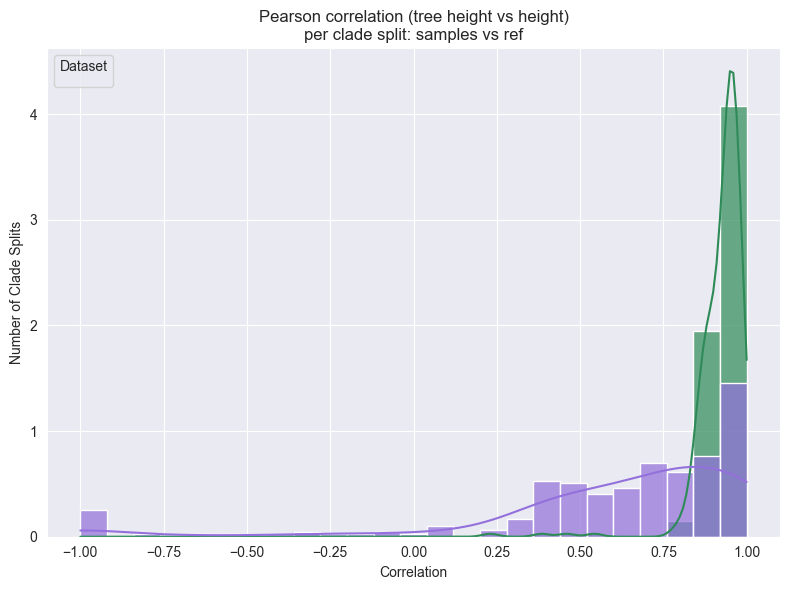

In [96]:
# 2. For each clade_split, calculate Pearson correlation in both sample and reference
def per_clade_child_corr(df):
    return (
        df.groupby('clade_split')
        .apply(
            lambda grp: grp['tree_height'].corr(grp['height'])
            if len(grp) > 1 else None
        )
        .dropna()
        .rename('correlation')
        .reset_index()
    )

sample_corr = per_clade_child_corr(df_sample_clade_branches).rename(columns={'correlation': 'correlation_sample'})
ref_corr = per_clade_child_corr(df_ref_clade_branches).rename(columns={'correlation': 'correlation_ref'})

# 3. Merge on clade_split -- only keep clade splits present in both for fair comparison
common_corrs = pd.merge(
    sample_corr,
    ref_corr,
    on='clade_split',
    how='inner'
)

# 4. Combine correlations into long format for joint histogram plotting
corrs_long = pd.melt(
    common_corrs,
    id_vars=['clade_split'],
    value_vars=['correlation_sample', 'correlation_ref'],
    var_name='dataset',
    value_name='correlation'
)
# Remap to 'samples' and 'ref' for legend
corrs_long['dataset'] = corrs_long['dataset'].map({
    'correlation_sample': 'samples',
    'correlation_ref': 'ref'
})

# 5. Plot histogram of the correlations for both sample and reference with legend "ref" and "samples"
plt.figure(figsize=(8,6))
ax = sns.histplot(
    data=corrs_long,
    x='correlation',
    hue='dataset',
    bins=25,
    kde=True,
    alpha=0.7,
    palette={'samples': 'mediumpurple', 'ref': 'seagreen'},
    stat="density"
)
plt.title("Pearson correlation (tree height vs height)\nper clade split: samples vs ref")
plt.xlabel("Correlation")
plt.ylabel("Number of Clade Splits")
plt.grid(True)
plt.tight_layout()

# Custom legend with order: 'ref', 'samples'
handles, labels = ax.get_legend_handles_labels()
new_labels = []
new_handles = []
# Ensure correct legend order
label_order = ['ref', 'samples']
for name in label_order:
    for (h, l) in zip(handles, labels):
        if l == name:
            new_handles.append(h)
            new_labels.append(l)
ax.legend(handles=new_handles, labels=new_labels, title='Dataset', loc='best', frameon=True)

plt.show()


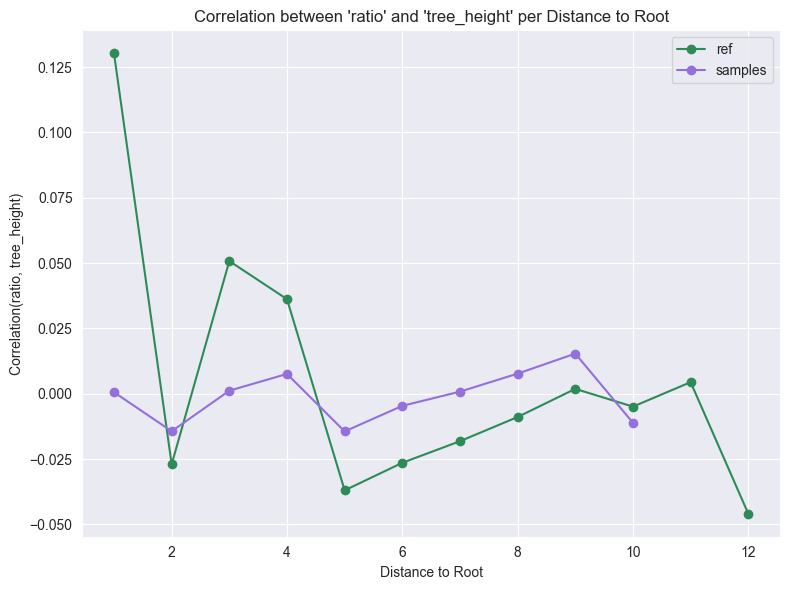

In [97]:
# Plot the correlation of 'ratio' and 'tree_height' per unique distance_to_root value (distance as x-axis, correlation as y-axis)
# Here, distance_to_root is assumed to be integer-valued

corrs_ref = []
corrs_sample = []
distance_values = sorted(set(df_ref_clade_branches['distance_to_root'].unique()) |
                        set(df_sample_clade_branches['distance_to_root'].unique()))

for d in distance_values:
    subref = df_ref_clade_branches[df_ref_clade_branches['distance_to_root'] == d]
    subsample = df_sample_clade_branches[df_sample_clade_branches['distance_to_root'] == d]
    corr_ref = subref[['ratio','tree_height']].corr().iloc[0,1] if len(subref) > 1 else np.nan
    corr_sample = subsample[['ratio','tree_height']].corr().iloc[0,1] if len(subsample) > 1 else np.nan
    corrs_ref.append(corr_ref if len(subref) > 5000 else np.nan)
    corrs_sample.append(corr_sample if len(subsample) > 5000 else np.nan)

plt.figure(figsize=(8,6))
plt.plot(distance_values, corrs_ref, marker='o', label='ref', color='seagreen')
plt.plot(distance_values, corrs_sample, marker='o', label='samples', color='mediumpurple')
plt.xlabel("Distance to Root")
plt.ylabel("Correlation(ratio, tree_height)")
plt.title("Correlation between 'ratio' and 'tree_height' per Distance to Root")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

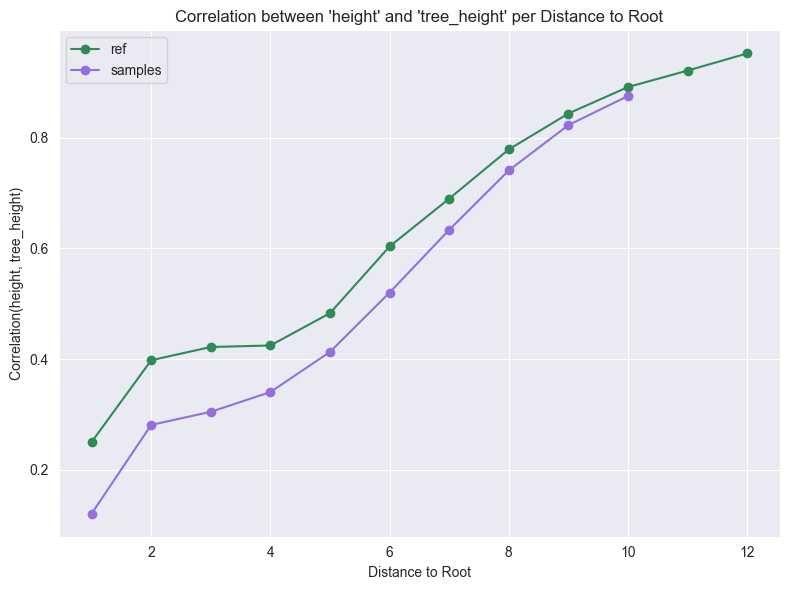

In [98]:
# Plot the correlation of 'height' and 'tree_height' per unique distance_to_root value (distance as x-axis, correlation as y-axis)
# Here, distance_to_root is assumed to be integer-valued

corrs_ref = []
corrs_sample = []
distance_values = sorted(set(df_ref_clade_branches['distance_to_root'].unique()) |
                        set(df_sample_clade_branches['distance_to_root'].unique()))

for d in distance_values:
    subref = df_ref_clade_branches[df_ref_clade_branches['distance_to_root'] == d]
    subsample = df_sample_clade_branches[df_sample_clade_branches['distance_to_root'] == d]
    corr_ref = subref[['height','tree_height']].corr().iloc[0,1] if len(subref) > 1 else np.nan
    corr_sample = subsample[['height','tree_height']].corr().iloc[0,1] if len(subsample) > 1 else np.nan
    corrs_ref.append(corr_ref if len(subref) > 5000 else np.nan)
    corrs_sample.append(corr_sample if len(subsample) > 5000 else np.nan)

plt.figure(figsize=(8,6))
plt.plot(distance_values, corrs_ref, marker='o', label='ref', color='seagreen')
plt.plot(distance_values, corrs_sample, marker='o', label='samples', color='mediumpurple')
plt.xlabel("Distance to Root")
plt.ylabel("Correlation(height, tree_height)")
plt.title("Correlation between 'height' and 'tree_height' per Distance to Root")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

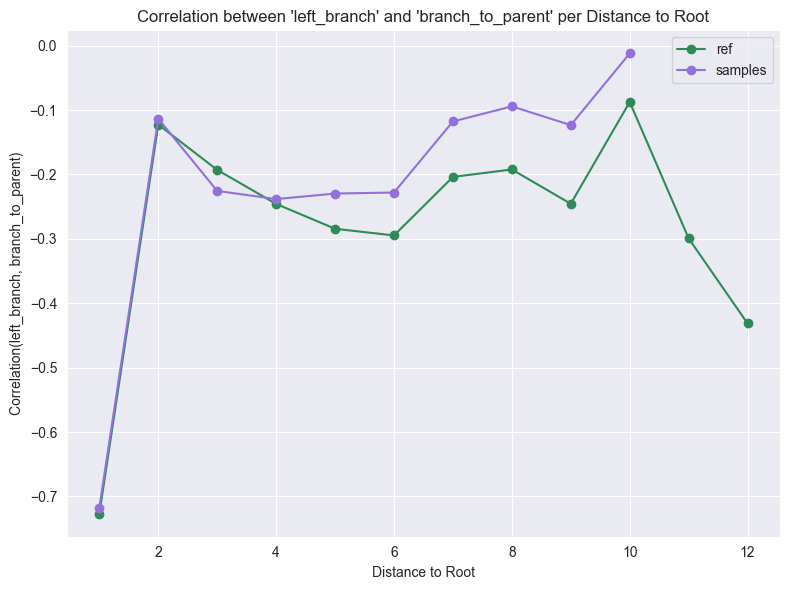

In [99]:
# Plot the correlation of 'left_branch' and 'branch_to_parent' per unique distance_to_root value (distance as x-axis, correlation as y-axis)
# Here, distance_to_root is assumed to be integer-valued

corrs_ref = []
corrs_sample = []
distance_values = sorted(set(df_ref_clade_branches['distance_to_root'].unique()) |
                        set(df_sample_clade_branches['distance_to_root'].unique()))

for d in distance_values:
    subref = df_ref_clade_branches[df_ref_clade_branches['distance_to_root'] == d]
    subsample = df_sample_clade_branches[df_sample_clade_branches['distance_to_root'] == d]
    corr_ref = subref[['left_branch','branch_to_parent']].corr().iloc[0,1] if len(subref) > 1 else np.nan
    corr_sample = subsample[['left_branch','branch_to_parent']].corr().iloc[0,1] if len(subsample) > 1 else np.nan
    corrs_ref.append(corr_ref if len(subref) > 5000 else np.nan)
    corrs_sample.append(corr_sample if len(subsample) > 5000 else np.nan)

plt.figure(figsize=(8,6))
plt.plot(distance_values, corrs_ref, marker='o', label='ref', color='seagreen')
plt.plot(distance_values, corrs_sample, marker='o', label='samples', color='mediumpurple')
plt.xlabel("Distance to Root")
plt.ylabel("Correlation(left_branch, branch_to_parent)")
plt.title("Correlation between 'left_branch' and 'branch_to_parent' per Distance to Root")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

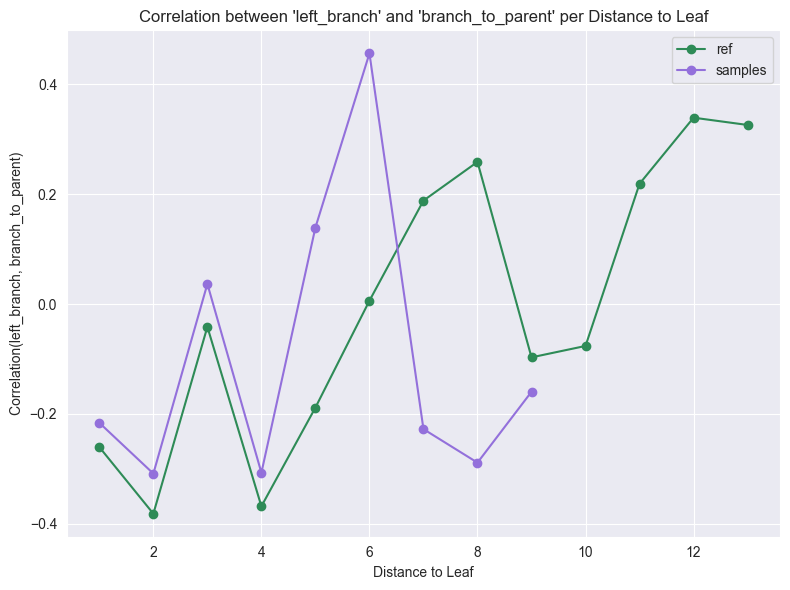

In [100]:
# Plot the correlation of 'left_branch' and 'branch_to_parent' per unique distance_to_leaf value (distance as x-axis, correlation as y-axis)
# Here, distance_to_leaf is assumed to be integer-valued

corrs_ref = []
corrs_sample = []
distance_values = sorted(set(df_ref_clade_branches['distance_to_leaf'].unique()) |
                        set(df_sample_clade_branches['distance_to_leaf'].unique()))

for d in distance_values:
    subref = df_ref_clade_branches[df_ref_clade_branches['distance_to_leaf'] == d]
    subsample = df_sample_clade_branches[df_sample_clade_branches['distance_to_leaf'] == d]
    corr_ref = subref[['left_branch','branch_to_parent']].corr().iloc[0,1] if len(subref) > 1 else np.nan
    corr_sample = subsample[['left_branch','branch_to_parent']].corr().iloc[0,1] if len(subsample) > 1 else np.nan
    corrs_ref.append(corr_ref if len(subref) > 5000 else np.nan)
    corrs_sample.append(corr_sample if len(subsample) > 5000 else np.nan)

plt.figure(figsize=(8,6))
plt.plot(distance_values, corrs_ref, marker='o', label='ref', color='seagreen')
plt.plot(distance_values, corrs_sample, marker='o', label='samples', color='mediumpurple')
plt.xlabel("Distance to Leaf")
plt.ylabel("Correlation(left_branch, branch_to_parent)")
plt.title("Correlation between 'left_branch' and 'branch_to_parent' per Distance to Leaf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()